<a href="https://colab.research.google.com/github/NishatVasker/CSE488_Big-Data-Analytics-/blob/main/lab0003.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install mrjob
import pandas as pd
from itertools import combinations
from mrjob.job import MRJob

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.6/439.6 kB 8.1 MB/s eta 0:00:00


Dataset Preview:
  Invoice StockCode                          Description  Quantity  \
0  536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1  536365     71053                  WHITE METAL LANTERN         6   
2  536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3  536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4  536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  Price  Customer ID         Country  
0 2010-12-01 08:26:00   2.55      17850.0  United Kingdom  
1 2010-12-01 08:26:00   3.39      17850.0  United Kingdom  
2 2010-12-01 08:26:00   2.75      17850.0  United Kingdom  
3 2010-12-01 08:26:00   3.39      17850.0  United Kingdom  
4 2010-12-01 08:26:00   3.39      17850.0  United Kingdom  

Top 10 Most Frequently Purchased Items:
Description
WHITE HANGING HEART T-LIGHT HOLDER    2369
REGENCY CAKESTAND 3 TIER              2200
JUMBO BAG RED RETROSPOT               2159
PARTY BUNTING       

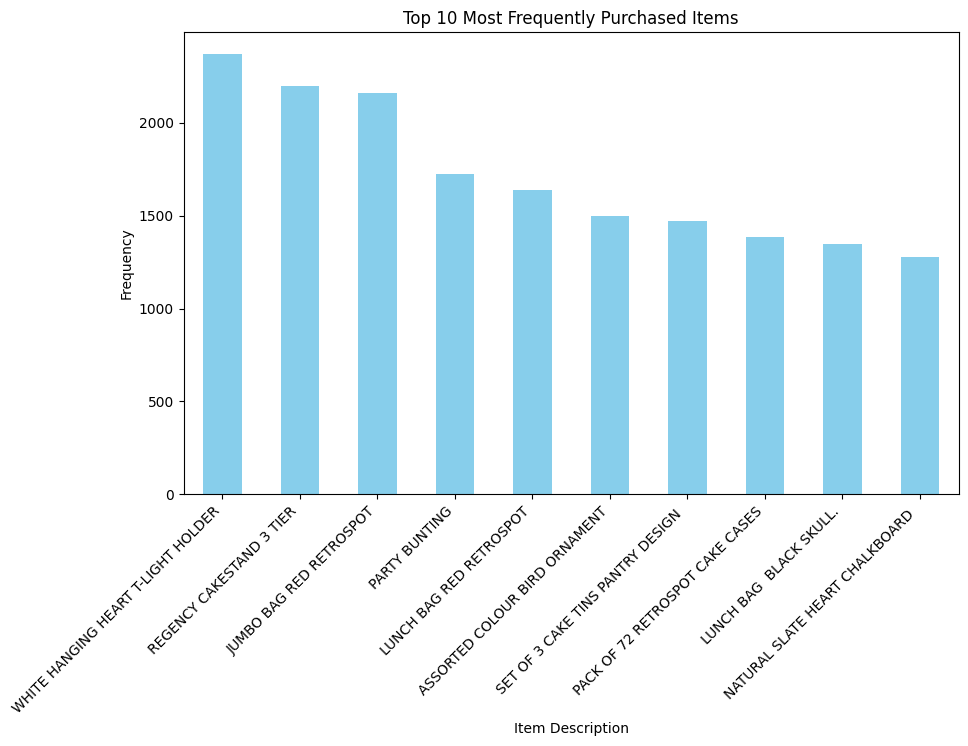

In [4]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
file_path = '/content/retail_data.xlsx'  # Replace with the correct dataset path
data = pd.read_excel(file_path, sheet_name='Year 2010-2011')

# Display the first few rows of the dataset
print("Dataset Preview:")
print(data.head())

# Analyze the dataset: count the most frequently purchased items
print("\nTop 10 Most Frequently Purchased Items:")
top_items = data['Description'].value_counts().head(10)
print(top_items)

# Visualize the top 10 most frequently purchased items
plt.figure(figsize=(10, 6))
top_items.plot(kind='bar', color='skyblue')
plt.title('Top 10 Most Frequently Purchased Items')
plt.xlabel('Item Description')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.show()


In [5]:
# Group transactions by Invoice, creating a list of items purchased per transaction
transactions = data.groupby('Invoice')['Description'].apply(list)

# Convert all items in transactions to strings and handle NaN values
transactions = transactions.apply(lambda x: [str(item) for item in x if pd.notna(item)])

# Save transactions to a text file (each line represents one transaction)
with open('transactions.txt', 'w') as f:
    for transaction in transactions:
        f.write(','.join(transaction) + '\n')

print("\nTransactions saved to 'transactions.txt' for frequent itemsets mining.")



Transactions saved to 'transactions.txt' for frequent itemsets mining.


In [6]:
# Save the MRJob script to a Python file
with open('frequent_itemsets_mr.py', 'w') as f:
    f.write("""
from mrjob.job import MRJob
from itertools import combinations

class MRFrequentItemsets(MRJob):
    def configure_args(self):
        super(MRFrequentItemsets, self).configure_args()
        self.add_passthru_arg('--min-support', type=int, default=2, help='Minimum support threshold')

    def mapper(self, _, line):
        items = line.strip().split(',')
        for itemset in combinations(items, 2):  # Generate pairs
            yield itemset, 1

    def combiner(self, itemset, counts):
        yield itemset, sum(counts)

    def reducer(self, itemset, counts):
        total_count = sum(counts)
        if total_count >= self.options.min_support:
            yield itemset, total_count

if __name__ == '__main__':
    MRFrequentItemsets.run()
    """)
print("\nfrequent_itemsets_mr.py has been saved.")



frequent_itemsets_mr.py has been saved.


In [7]:
# Install mrjob if not already installed
!pip install mrjob

# Run the MapReduce job on the transactions file
!python frequent_itemsets_mr.py transactions.txt --min-support 2 > output.txt

print("\nFrequent itemsets mining complete. Results saved to 'output.txt'.")


No configs found; falling back on auto-configuration
No configs specified for inline runner
Creating temp directory /tmp/frequent_itemsets_mr.root.20241120.180958.225621
Running step 1 of 1...
job output is in /tmp/frequent_itemsets_mr.root.20241120.180958.225621/output
Streaming final output from /tmp/frequent_itemsets_mr.root.20241120.180958.225621/output...
Removing temp directory /tmp/frequent_itemsets_mr.root.20241120.180958.225621...

Frequent itemsets mining complete. Results saved to 'output.txt'.


In [8]:
# Parse frequent itemsets from the output file
frequent_itemsets = []
with open('output.txt', 'r') as f:
    for line in f:
        line = line.strip()
        if not line:  # Skip empty lines
            continue

        # Split the line into itemset and count
        parts = line.rsplit('\t', 1)
        itemset_str, count_str = parts[0], parts[1]

        # Parse the itemset and count
        itemset = itemset_str.strip('[]').replace('"', '').split(', ')
        itemset = [item.strip() for item in itemset]  # Clean up item names
        count = int(count_str)  # Convert count to integer
        frequent_itemsets.append((set(itemset), count))

print("\nFrequent Itemsets Parsed:")
for itemset, count in frequent_itemsets:
    print(f"Itemset: {itemset}, Count: {count}")


Streaming output truncated to the last 5000 lines.
Itemset: {'SEASIDE FLYING DISC', 'GUMBALL MAGAZINE RACK'}, Count: 8
Itemset: {'SEASIDE FLYING DISC', 'GYMKHANA TREASURE BOOK BOX'}, Count: 7
Itemset: {'HAND OVER THE CHOCOLATE   SIGN', 'SEASIDE FLYING DISC'}, Count: 11
Itemset: {'HAND WARMER BABUSHKA DESIGN', 'SEASIDE FLYING DISC'}, Count: 4
Itemset: {'HAND WARMER BIRD DESIGN', 'SEASIDE FLYING DISC'}, Count: 10
Itemset: {'SEASIDE FLYING DISC', 'HAND WARMER OWL DESIGN'}, Count: 11
Itemset: {'SEASIDE FLYING DISC', 'HAND WARMER RED LOVE HEART'}, Count: 6
Itemset: {'SEASIDE FLYING DISC', 'HAND WARMER RED RETROSPOT'}, Count: 2
Itemset: {'SEASIDE FLYING DISC', 'HAND WARMER SCOTTY DOG DESIGN'}, Count: 10
Itemset: {'HAND WARMER UNION JACK', 'SEASIDE FLYING DISC'}, Count: 2
Itemset: {'SEASIDE FLYING DISC', 'HANGING CHICK  YELLOW DECORATION'}, Count: 3
Itemset: {'SEASIDE FLYING DISC', 'HANGING FAIRY CAKE DECORATION'}, Count: 10
Itemset: {'HANGING HEART BONHEUR', 'SEASIDE FLYING DISC'}, Count: 3


In [ ]:
# Generate association rules from frequent itemsets
def generate_association_rules(frequent_itemsets, min_confidence=0.6):
    rules = []
    for itemset, support in frequent_itemsets:
        if len(itemset) > 1:  # Only generate rules for itemsets with 2 or more items
            for item in itemset:
                antecedent = itemset - {item}
                consequent = {item}
                antecedent_support = next(
                    (sup for items, sup in frequent_itemsets if items == antecedent), 0
                )
                if antecedent_support > 0:  # Avoid division by zero
                    confidence = support / antecedent_support
                    if confidence >= min_confidence:
                        rules.append((antecedent, consequent, confidence))
    return rules

# Generate rules with a confidence threshold of 0.6
association_rules = generate_association_rules(frequent_itemsets, min_confidence=0.6)

# Display the generated association rules
print("\nAssociation Rules:")
if not association_rules:
    print("No association rules generated.")
else:
    for antecedent, consequent, confidence in association_rules:
        print(f"Rule: {antecedent} -> {consequent} (Confidence: {confidence:.2f})")
